In [37]:
from sklearn.feature_selection import SelectPercentile, SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.decomposition import PCA

from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.nn import relu

import pandas as pd
import matplotlib.pyplot as plt
from json import load as json_load
from json import dump as json_dump

## Training parameters

In [2]:
# limit of input data size
rows_limit = 40000

# which features and label to consider
selected_features = ['dates', 'categories', 'vectors', 'tfidf'] # ['dates', 'categories', 'vectors', 'tfidf']
selected_label = 'rage_cat'

# min count for idf
min_count = 100

# features selection
select_method = 'percents' # 'percents'
no_features = 10000
features_percentile = 70

#       ['replies', 'upvotes', 'downvotes', 'rage', 'joy', 'sadness', 'surprise',
#        'fear', 'reactions', 'reactions_sentiment', 'replies_cat',
#        'upvotes_cat', 'downvotes_cat', 'reactions_cat',
#        'reactions_sentiment_cat', 'rage_cat', 'joy_cat', 'sadness_cat',
#        'surprise_cat', 'fear_cat']

## Data reading

In [3]:
df = pd.read_csv('labeling/fresh_data.csv', nrows = rows_limit)\
    .set_index('id')\
    .drop_duplicates(keep = 'first')
df = df.drop(['title', 'highlight', 'content', 'media_desc'], axis = 1)

In [4]:
df.head(3)

,div,date,author,media_type,replies,upvotes,downvotes,rage,joy,sadness,surprise,fear,reactions,reactions_sentiment
id,,,,,,,,,,,,,,
24247530,dekomunizacja ulic,2018-12-06 13:00:00,Jarosław Osowski,image,7,44,1,0,2,0,0,2,45,0.98
24593465,CBA,2019-03-28 13:40:00,mch,image,3,9,0,0,0,0,0,0,9,1.00
24376781,Kraj,2019-01-18 14:17:00,Antonio Tajani,image,28,567,10,0,3,0,0,8,577,0.98


## Data preparation

In [5]:
labels_columns = ['replies', 'upvotes', 'downvotes', 'rage', 'joy', 'sadness', 'surprise', 
                  'fear', 'reactions', 'reactions_sentiment']
labels_df = df[[selected_label.split('_')[0]]]
df = df.drop(labels_columns, axis = 1)

In [6]:
def process_dates(df):
    df['date'] = pd.to_datetime(df['date'])
    df = pd.concat([
        df,
        pd.get_dummies(df['date'].dt.weekday, prefix = 'weekday'),
        pd.get_dummies(df['date'].dt.hour, prefix = 'hour'),
    ], axis = 1)
    return df

In [7]:
df.shape

(35233, 4)

In [8]:
if 'dates' in selected_features:
    df = process_dates(df)
df = df.drop('date', axis = 1)

In [9]:
df.shape

(35233, 34)

In [33]:
def process_author_div_and_media_type(df):
    column_names = {}
    column_names["author"] = pd.get_dummies(df['author']).columns.tolist()
    column_names["div"] = pd.get_dummies(df['div']).columns.tolist()
    column_names["media_type"] = pd.get_dummies(df['media_type']).columns.tolist()
    df = pd.concat([
        df,
        pd.get_dummies(df['author'], prefix = 'author'),
        pd.get_dummies(df['div'], prefix = 'div'),
        pd.get_dummies(df['media_type'], prefix = 'media_type')
    ], axis = 1)
    return df, column_names

In [34]:
if 'categories' in selected_features:
    df, column_names = process_author_div_and_media_type(df)
df = df.drop(['author', 'div', 'media_type'], axis = 1)

In [40]:
for d_key, d_list in column_names.items():
    with open('labeling/'+d_key+"_dict", 'w') as f:
        json_dump(d_list, f)
        print(len(d_list))
        print(d_key)

3837
div
3
media_type
1475
author


In [13]:
df.shape

(35233, 5346)

In [16]:
5346 - 34 + 3

5315

In [15]:
1476 + 3 + 3838

5317

In [11]:
df.head(3)

,weekday_0.0,weekday_1.0,weekday_2.0,weekday_3.0,weekday_4.0,weekday_5.0,weekday_6.0,hour_0.0,hour_1.0,hour_2.0,...,div_żuławski tulipan,div_żuławy,div_żużel,div_żydzi,div_żydzi w warszawie,div_żywność,div_żłobki,media_type_image,media_type_multiple_images,media_type_video
id,,,,,,,,,,,,,,,,,,,,,
24247530,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
24593465,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
24376781,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [12]:
df.shape

(35233, 5346)

In [13]:
def add_vectors(columns, index, labels_df):
    column_vectors = []
    pca_dict = {}
    for column in columns:
        tmp = pd.read_csv('labeling/'+column+'_vec').set_index('id').reindex(index)
        pca = PCA(n_components = 50)
        pca.fit(tmp.values, labels_df.values)
        tmp_values = pca.transform(tmp.values)
        tmp = pd.DataFrame(tmp_values, index = index)
        tmp.columns = [column+"_"+str(x) for x in range(len(tmp.columns))]
        column_vectors.append(tmp)
        pca_dict[column] = pca
    return pd.concat(column_vectors, axis = 1), pca_dict

In [14]:
if 'vectors' in selected_features:
    vectors, pca_vectors = add_vectors(['content', 'highlight', 'title', 'media_desc'], df.index, labels_df)
    df = pd.concat([df, vectors], axis = 1)

In [17]:
df.head(5)

,weekday_0.0,weekday_1.0,weekday_2.0,weekday_3.0,weekday_4.0,weekday_5.0,weekday_6.0,hour_0.0,hour_1.0,hour_2.0,...,media_desc_40,media_desc_41,media_desc_42,media_desc_43,media_desc_44,media_desc_45,media_desc_46,media_desc_47,media_desc_48,media_desc_49
id,,,,,,,,,,,,,,,,,,,,,
24247530,0,0,0,1,0,0,0,0,0,0,...,-0.052617,-0.087159,0.007548,-0.000144,0.023022,-0.137771,-0.245355,0.046738,-0.002610,0.126668
24593465,0,0,0,1,0,0,0,0,0,0,...,-0.003857,-0.001148,0.010434,0.007388,-0.004525,0.001568,0.002805,0.001702,0.001177,-0.000242
24376781,0,0,0,0,1,0,0,0,0,0,...,0.130681,0.029628,-0.022455,-0.355337,0.096901,0.111422,0.005927,0.072138,-0.023228,-0.032665
22852664,0,0,1,0,0,0,0,0,0,0,...,-0.150608,0.050769,-0.029463,0.043296,-0.187217,0.152652,0.279605,-0.075095,-0.034097,0.075607
24320164,1,0,0,0,0,0,0,0,0,0,...,0.082357,0.076234,-0.089086,0.149493,-0.009153,-0.207634,0.165732,0.064681,0.035481,0.019499


In [18]:
df.shape

(35233, 5546)

In [19]:
from json import load
import numpy as np
from collections import Counter

In [20]:
with open('labeling/idf_dict', 'r') as f:
    idf = {key: value for key, value in load(f).items() if value >= min_count}
    idf_voc = idf.keys()

In [21]:
lemmas = pd.read_csv('labeling/lemmatized_articles.csv', nrows = rows_limit).set_index('id').fillna('')

In [22]:
lemmas.head(1)

,content,highlight,media_desc,title
id,,,,
24247530,piatkowej wokanda nsa figurowac nazwa stoleczn...,naczelny sad administracyjny rozny finalizowac...,marzec zakladanie nowy tablica dawny al armia ...,czas wyczekiwac final dekomunizacja ulica piat...


In [23]:
def add_tf_idf(columns, index, labels_df):
    whole_string = ''
    for column in columns:
        whole_string = whole_string + lemmas[column] + ' '
    tf_idf = []
    for record in whole_string.values:
        return_record = []
        counts = dict(Counter(record.split(' ')))
        for feature_word in idf_voc:
            if feature_word in counts.keys():
                return_record.append(counts[feature_word]/idf[feature_word])
            else:
                return_record.append(0)
        tf_idf.append(return_record)
        
    tmp = pd.DataFrame(tf_idf, index = index)
    pca = PCA(n_components = int(len(tmp.columns)*0.2))
    pca.fit(tmp.values, labels_df.values)
    tmp_values = pca.transform(tmp.values)
    tmp = pd.DataFrame(tmp_values, index = index)
    tmp.columns = ['tf_idf_'+str(x) for x in range(len(tmp.columns))]
    
    return tmp, pca

In [24]:
if 'tfidf' in selected_features:
    tfidf_col, tfidf_pca = add_tf_idf(['content', 'highlight', 'title', 'media_desc'], df.index, labels_df)
    df = pd.concat([df, tfidf_col], axis = 1)

In [25]:
df.shape

(35233, 6905)

In [26]:
labels_df.shape

(35233, 1)

## Categorize labels

In [27]:
import matplotlib.pyplot as plt

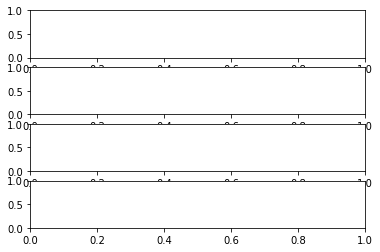

In [28]:
fig, axes = plt.subplots(4)
for i, column in enumerate(['replies', 'upvotes', 'downvotes', 'reactions']):
    try:
        threshold = labels_df[column].quantile(0.9)
        print(threshold)
        labels_df.loc[labels_df[column] > threshold, column] = threshold
        labels_df[column].plot(kind = 'hist', bins = 100, figsize= (15,10), title = column, ax = axes[i])
    except:
        pass

In [29]:
try:
    labels_df['reactions_sentiment'] = labels_df['reactions_sentiment'].fillna(0)
except:
    pass

In [30]:
categories = []
categories_columns = ['replies', 'upvotes', 'downvotes', 'reactions', 
                      'reactions_sentiment', 'rage', 'joy', 'sadness',
                      'surprise', 'fear']
for column in categories_columns:
    try:
        categories.append(pd.qcut(labels_df[column], 3, labels = [-1, 0, 1]))
    except:
        pass
try:
    tmp_cat = pd.concat(categories, axis = 1)
    tmp_cat.columns = [selected_label.split('_')[0]+"_cat_3"]
    labels_df = pd.concat([labels_df, tmp_cat], axis = 1)
except:
    pass

In [31]:
labels_df.head(3)

,rage
id,
24247530,0
24593465,0
24376781,0


In [32]:
for emotion in ['rage', 'joy', 'sadness', 'surprise', 'fear']:
    try:
        labels_df.loc[labels_df[emotion] == 0, emotion+'_cat'] = 0
        labels_df.loc[labels_df[emotion] != 0, emotion+'_cat'] = 1
    except:
        pass

In [33]:
try:
    labels_df.loc[labels_df['replies'] > 10, 'replies_cat'] = 1
    labels_df.loc[labels_df['replies'] <= 10, 'replies_cat'] = 0
except:
    pass

In [34]:
# fig, axes = plt.subplots(1, 5, figsize = (20,3))
# for i, emotion_cat in enumerate(['rage_cat', 'joy_cat', 'sadness_cat', 'surprise_cat', 'fear_cat']):
#     labels_df[[emotion_cat]].reset_index().groupby(emotion_cat).count().plot(kind = 'bar', ax = axes[i])

### Check for NaN

In [35]:
df[df.isna().any(axis=1)]

,weekday_0.0,weekday_1.0,weekday_2.0,weekday_3.0,weekday_4.0,weekday_5.0,weekday_6.0,hour_0.0,hour_1.0,hour_2.0,...,tf_idf_1349,tf_idf_1350,tf_idf_1351,tf_idf_1352,tf_idf_1353,tf_idf_1354,tf_idf_1355,tf_idf_1356,tf_idf_1357,tf_idf_1358
id,,,,,,,,,,,,,,,,,,,,,


In [36]:
labels_df[labels_df.isna().any(axis=1)]

,rage,rage_cat
id,,


## Normalize labels

In [37]:
def normalize_labels(df, labels_df, selected_label):
    label_counts = labels_df[[selected_label]]\
        .reset_index()\
        .groupby(selected_label)\
        .count()\
        .sort_values('id')
    
    less_label_name = label_counts\
        .iloc[0]\
        .name
    
    multiplier = round(label_counts.iloc[1].id/label_counts.iloc[0].id)
    
    less_label_df = labels_df[labels_df[selected_label] == less_label_name]
    main_df_less_labels_records = df[df.index.isin(less_label_df.index)]
    
    for i in range(int(multiplier)):
        labels_df = labels_df.append(less_label_df)
        df = df.append(main_df_less_labels_records)
    
    label_counts = labels_df[[selected_label]]\
        .reset_index()\
        .groupby(selected_label)\
        .count()\
        .sort_values('id')\
        .reset_index()
    
    flatten_more = label_counts[label_counts[selected_label] == less_label_name].id.values[0]
    flatten_less = label_counts[label_counts[selected_label] != less_label_name].id.values[0]
    excess = flatten_more - flatten_less
    
    labels_df = labels_df.iloc[:len(labels_df) - excess]
    df = df.iloc[:len(df) - excess]
    
    labels_df = labels_df.reset_index().sample(frac = 1)
    df = df.reset_index().reindex(labels_df.index)
    
    return df, labels_df

In [38]:
if selected_label.split('_')[0] in ('fear', 'sadness', 'joy', 'surprise', 'rage'):
    df, labels_df = normalize_labels(df, labels_df, selected_label)

In [39]:
labels_df.shape

(58168, 3)

In [40]:
df.shape

(58168, 6906)

## Features selection

In [41]:
try:
    df = df.drop('id', axis = 1)
    labels_df = labels_df.drop('id', axis = 1)
except:
    pass

In [42]:
X = df.values

In [43]:
Y = labels_df[[selected_label]].values

In [44]:
if select_method == 'kbest':
    clf = SelectKBest(f_classif, k=no_features).fit(X, Y)
elif select_method == 'percents':
    clf = SelectPercentile(f_classif, percentile = features_percentile).fit(X, Y)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [45]:
selected_columns = df.columns[clf.get_support()].tolist()

In [46]:
X.shape

(58168, 6905)

In [47]:
X = clf.transform(X)

In [48]:
X.shape

(58168, 4833)

In [49]:
Y.shape

(58168, 1)

## Define X and Y for training/testing

In [50]:
s = int(len(df)*0.95)

In [51]:
s

55259

In [52]:
train_x = X[:s]
train_y = Y[:s]

In [53]:
test_x = X[s:]
test_y = Y[s:]

## Training

In [54]:
inputs = Input(shape = (X.shape[1], ))

In [55]:
hidden_1 = Dense(int(X.shape[1]/20)+60, activation = relu)(inputs)
dropout_1 = Dropout(0.1)(hidden_1)
hidden_2 = Dense(int(X.shape[1]/100)+30, activation = relu)(dropout_1)
dropout_2 = Dropout(0.1)(hidden_2)
hidden_3 = Dense(int(X.shape[1]/500)+5, activation = relu)(dropout_2)

W0806 08:53:50.437872 139806765098752 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [56]:
outputs = Dense(1)(hidden_3)

In [57]:
model = Model(
    inputs = inputs,
    outputs = outputs
)

In [58]:
from tensorflow.keras.optimizers import RMSprop

In [59]:
optimizer = RMSprop(0.0005)

In [60]:
from tensorflow.losses import *

In [61]:
model.compile(
    loss=mean_squared_error,
    optimizer=optimizer,
    metrics=['mean_absolute_error']
)

W0806 08:53:50.654711 139806765098752 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [62]:
example_batch = test_x[:5]
print(model.predict(example_batch))

[[-0.00185085]
 [ 0.05504609]
 [ 0.04935109]
 [ 0.04774774]
 [ 0.02664548]]


In [63]:
EPOCHS = 100

In [64]:
from tensorflow.keras.callbacks import EarlyStopping

In [65]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [66]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4833)]            0         
_________________________________________________________________
dense (Dense)                (None, 301)               1455034   
_________________________________________________________________
dropout (Dropout)            (None, 301)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 78)                23556     
_________________________________________________________________
dropout_1 (Dropout)          (None, 78)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 14)                1106      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 15    

In [67]:
history = model.fit(
    train_x, train_y,
    epochs = EPOCHS,
    validation_split = 0.15, 
    verbose = 0,
    callbacks = [early_stop],
)

In [68]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    m = max(max([history.history['mean_absolute_error'] + history.history['val_mean_absolute_error']]))
    plt.ylim([0,m * 1.1])
    plt.legend()

In [69]:
loss, mae = model.evaluate(test_x, test_y, verbose=0)

In [70]:
mae

0.11232338

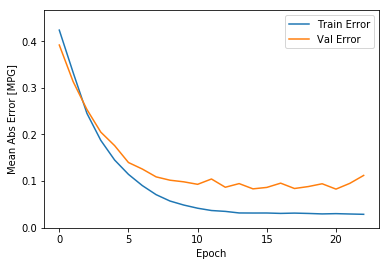

In [71]:
plot_history(history)

In [72]:
res = pd.concat([pd.DataFrame(model.predict(test_x)), pd.DataFrame(test_y)], axis = 1)
res.columns = ['prediction', 'real']
no_categories = len(res['real'].unique())

In [73]:
if no_categories == 2:
    mean = res['prediction'].mean()
    res.loc[res['prediction'] < mean, 'prediction_cat'] = 0
    res.loc[res['prediction'] >= mean, 'prediction_cat'] = 1
elif no_categories == 3:
    res.loc[res['prediction'] < -0.66, 'prediction_cat'] = -1
    res.loc[res['prediction'] >  0.66, 'prediction_cat'] = 1
    res['prediction_cat'] = res['prediction_cat'].fillna(0)

In [74]:
res.loc[res['real'] == res['prediction_cat'], 'if_ok'] = 1
res['if_ok'] = res['if_ok'].fillna(0)

In [75]:
res.sample(frac=1).head(10)

,prediction,real,prediction_cat,if_ok
2152,0.455007,0.0,0.0,1.0
2195,0.979551,1.0,1.0,1.0
220,0.430218,0.0,0.0,1.0
291,0.976277,1.0,1.0,1.0
836,0.020026,0.0,0.0,1.0
2704,0.968865,1.0,1.0,1.0
1557,0.963540,1.0,1.0,1.0
1492,0.961025,1.0,1.0,1.0
1300,0.966960,1.0,1.0,1.0
1187,0.968383,1.0,1.0,1.0


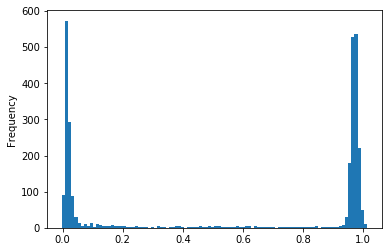

In [76]:
res['prediction'].plot(kind = 'hist', bins = 100)

In [77]:
print('accuracy: ',round(res['if_ok'].sum()/len(res)*100, 2), '%')

accuracy:  91.58 %


In [78]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

In [79]:
if no_categories == 2:
    c = [0,1]
else:
    c = [-1,0,1]

In [80]:
confusion_data = confusion_matrix(res['real'], res['prediction_cat'])

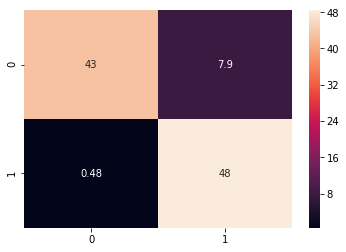

In [81]:
heatmap(np.multiply(np.divide(confusion_data, confusion_data.sum()), 100), xticklabels = c, yticklabels = c, annot=True)

In [82]:
from joblib import dump

In [83]:
model.save('models/'+selected_label)
dump(tfidf_pca,'tfidf_pca_'+selected_label)
dump(pca_vectors,'vectors_pca_'+selected_label)
dump(clf,'feature_selection_'+selected_label)

['feature_selection_rage_cat']

#AAA

In [97]:
from joblib import load

In [98]:
pca = load('models/vectors_pca_rage_cat')

In [95]:
from tensorflow.keras.models import load_model

In [96]:
a = load_model('models/rage_cat')

W0806 11:51:58.152657 139806765098752 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0806 11:51:58.154669 139806765098752 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
